In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import os
from config import PARAS
import warnings

warnings.filterwarnings('ignore')
audio_path = '../../separated_data/audio'
SR = 16000

In [2]:
audio_list = []
for (dirpath, dirnames, filenames) in os.walk(audio_path):
    if not dirnames:
        audio_list.extend(filenames)

In [3]:
audio_list

['akwvpAiLFk0-144.680000-150.000000.wav',
 'AvWWVOgaMlk-090.000000-093.566667.wav',
 'CJoOwXcjhds-233.266000-239.367000.wav',
 'Swss72CHSWg-090.023267-097.297200.wav',
 'Y8HMIm8mdns-171.607767-174.607767.wav',
 'ymD5uLlLc0g-036.033000-040.900000.wav']

In [4]:
from mel_dealer import mel_converter
def frame_feature_extractor(signal, mel_converter=mel_converter):
    """
    Takes in new signals and create mel chunks 
    """
    S = mel_converter.signal_to_melspec(signal)
    print(S.shape)
    if not S.shape[0] % (2*PARAS.N_MEL) == 0:
        S = S[:-1 * (S.shape[0] % (2*PARAS.N_MEL))] # divide the mel spectrogram
        
    chunk_num = int(S.shape[0] / (2*PARAS.N_MEL))
    mel_chunks = np.split(S, chunk_num) # create 150 * 150 data frames
    return mel_chunks[0]

In [5]:
audio_1, sr = librosa.load(audio_path + '/' + audio_list[0], sr=SR)

In [6]:
mel_spec = frame_feature_extractor(audio_1, mel_converter=mel_converter)

(668, 128)


In [7]:
mel_spec.shape

(256, 128)

In [8]:
from IPython.display import Audio
print(audio_1.shape)
Audio(audio_1, rate=sr)


(85450,)


In [9]:
res_signal = mel_converter.m(mel_spec, log=True, phase=None, transpose=True, audio_out=False)

In [10]:
print(res_signal.shape)
Audio(res_signal, rate=sr)

(32640,)


In [11]:
mel_spec_ = frame_feature_extractor(res_signal, mel_converter=mel_converter)
mel_spec_.shape

(256, 128)


(256, 128)

In [12]:
res_signal_ = mel_converter.m(mel_spec_, log=True, phase=None, transpose=True, audio_out=False)
print(res_signal_.shape)
Audio(res_signal_, rate=sr)

(32640,)


In [13]:
mixture_path = '../../Unetdata/mixture_data/audio'
normalize_audio_path = '../../Unetdata/norm_data/audio'

In [14]:
f = audio_list
for i in range(len(f)):
    path1 = f[i]
    name1 = path1[:-4]
    path1 = name1 + '.wav'

    path2_count = i + 1
    if path2_count == len(f):
        break
    while filenames[path2_count][:11] not in path1:
        path2 = f[path2_count]
        name2 = path2[:-4]
        path2 = name2 + '.wav'
        signal1, _ = librosa.load(audio_path + '/' + path1, sr=SR)
        signal2, _ = librosa.load(audio_path + '/' + path2, sr=SR)
                
        mel_spec_1 = frame_feature_extractor(signal1, mel_converter=mel_converter)
        mel_spec_2 = frame_feature_extractor(signal2, mel_converter=mel_converter)
        
        res_signal_1 = mel_converter.m(mel_spec_1, log=True, phase=None, transpose=True, audio_out=False)
        res_signal_2 = mel_converter.m(mel_spec_2, log=True, phase=None, transpose=True, audio_out=False)
        
        signal1_n2 = librosa.util.normalize(res_signal_1, norm=2)
        signal2_n2 = librosa.util.normalize(res_signal_2, norm=2)
        
        signal3 = signal1_n2 + signal2_n2
        
        try:
            os.makedirs(normalize_audio_path)
        except FileExistsError:
            pass
        dir1 = normalize_audio_path + '/' + name1 + '.wav'
        sf.write(dir1, signal1_n2, samplerate=SR)
        dir2 = normalize_audio_path + '/' + name2 + '.wav'
        sf.write(dir2, signal2_n2, samplerate=SR)
        
        try:
            os.makedirs(mixture_path)
        except FileExistsError:
            pass
        name3 = name1 + '~' + name2 + '.wav'
        dir3 = mixture_path + '/' + name3
        sf.write(dir3, signal3, samplerate=SR)
        
        if path2_count == len(f)-1:
            break
        path2_count += 1
        

(668, 128)
(447, 128)
(668, 128)
(764, 128)
(668, 128)
(912, 128)
(668, 128)
(378, 128)
(668, 128)
(610, 128)
(447, 128)
(764, 128)
(447, 128)
(912, 128)
(447, 128)
(378, 128)
(447, 128)
(610, 128)
(764, 128)
(912, 128)
(764, 128)
(378, 128)
(764, 128)
(610, 128)
(912, 128)
(378, 128)
(912, 128)
(610, 128)
(378, 128)
(610, 128)


In [15]:
import h5py
h5py_path = '../../Unetdata/dataset'
f = []
for (dirpath, dirnames, filenames) in os.walk(mixture_path):
    f.extend(filenames)
    break
    
try:
    os.makedirs(h5py_path)
except FileExistsError:
    pass
tr_name = h5py_path + '/' + 'tr_set.hdf5'
val_name = h5py_path + '/' + 'val_set.hdf5'
test_name = h5py_path + '/' + 'test_set.hdf5'
tr_dataset = h5py.File(tr_name, 'a')
val_dataset = h5py.File(val_name, 'a')
test_dataset = h5py.File(test_name, 'a')
for i in range(len(f)):
    file_mix = f[i]
    file_1, file_2 = file_mix.split('~')
    file_2 = file_2[:-4]
    path_mix = mixture_path + '/' + file_mix
    path_1 = normalize_audio_path + '/' + file_1 + '.wav'
    path_2 = normalize_audio_path + '/' + file_2 + '.wav'
    signal_mix, _ = librosa.load(path_mix, sr=SR)
    signal_1, _ = librosa.load(path_1, sr=SR)
    signal_2, _ = librosa.load(path_2, sr=SR)
    mel_mix = frame_feature_extractor(signal_mix, mel_converter=mel_converter)
    mel_1 = frame_feature_extractor(signal_1, mel_converter=mel_converter)
    mel_2 = frame_feature_extractor(signal_2, mel_converter=mel_converter)

    if i < 2000:
        if i == 0:
            tr_dataset.create_dataset('spec_mix', shape=(2000, 256, 128), dtype=np.float32)
            tr_dataset.create_dataset('spec_1', shape=(2000, 256, 128), dtype=np.float32)
            tr_dataset.create_dataset('spec_2', shape=(2000, 256, 128), dtype=np.float32)

        tr_dataset['spec_mix'][i] = mel_mix
        tr_dataset['spec_1'][i] = mel_1
        tr_dataset['spec_2'][i] = mel_2

    elif i < 2500:
        if i == 2000:
            val_dataset.create_dataset('spec_mix', shape=(500, 256, 128), dtype=np.float32)
            val_dataset.create_dataset('spec_1', shape=(500, 256, 128), dtype=np.float32)
            val_dataset.create_dataset('spec_2', shape=(500, 256, 128), dtype=np.float32)

        val_dataset['spec_mix'][i-2000] = mel_mix
        val_dataset['spec_1'][i-2000] = mel_1
        val_dataset['spec_2'][i-2000] = mel_2

    elif i < 3000:

        if i == 2500:
            test_dataset.create_dataset('spec_mix', shape=(500, 256, 128), dtype=np.float32)
            test_dataset.create_dataset('spec_1', shape=(500, 256, 128), dtype=np.float32)

        test_dataset['spec_mix'][i-2500] = mel_mix
        test_dataset['spec_1'][i-2500] = mel_1
        test_dataset['spec_2'][i-2500] = mel_2

    else:
        break


tr_dataset.close()
val_dataset.close()
test_dataset.close()

(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)


In [16]:
def create_gt_mask(vocal_spec, bg_spec):
    """
    Take in log spectrogram and return a mask map for TF bins
    1 if the vocal sound is dominated in the TF-bin, while 0 for not
    """
#    vocal_spec = vocal_spec.numpy()
#    bg_spec = bg_spec.numpy()
    return np.array(vocal_spec > bg_spec, dtype=np.float32)
def data_generator(dataset_path, batch_size):
    dataset = h5py.File(dataset_path, 'a')
    spec_mix = dataset['spec_mix']
    spec_mix = np.array(spec_mix)
    
    spec_1 = dataset['spec_1']
    spec_1 = np.array(spec_1)
    
    spec_2 = dataset['spec_2']
    spec_2 = np.array(spec_2)
    
    spec_1_mask = create_gt_mask(spec_1, spec_2)
    spec_2_mask = create_gt_mask(spec_2, spec_1)
    
    set_new = True
    while True:
        for i in range(spec_mix.shape[0]):
            if set_new:
                input_spec_mix = np.zeros((batch_size, 256, 128))
                output_spec_1 = np.zeros((batch_size, 256, 128))
                output_spec_2 = np.zeros((batch_size, 256, 128))
                batch_index = 0
                set_new = False
                
            input_spec_mix[batch_index,:,:] = spec_mix[i,:,:]
            output_spec_1[batch_index,:,:] = spec_1_mask[i,:,:]
            output_spec_2[batch_index,:,:] = spec_2_mask[i,:,:]
            batch_index += 1
            
            if batch_index == batch_size:
                set_new = True
                batch_index = 0
                input_spec_mix = np.expand_dims(input_spec_mix, axis = -1)
                output_spec_1 = np.expand_dims(output_spec_1, axis = -1)
                output_spec_2 = np.expand_dims(output_spec_2, axis = -1)
                yield [input_spec_mix], [output_spec_1, output_spec_2]

In [19]:
tr_path = h5py_path + '/' + 'tr_set.hdf5'
batch_size = 2
train_generator = data_generator(tr_path, batch_size)

In [20]:
[input_spec_mix], [output_spec_1, output_spec_2] = next(train_generator)

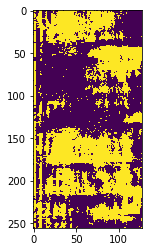

In [25]:
import matplotlib.pyplot as plt
plt.imshow(output_spec_1[0,:,:,0])

In [26]:
h5py_path = '../../Unetdata/dataset'
tr_path = h5py_path + '/' + 'tr_set.hdf5'
val_path = h5py_path + '/' + 'val_set.hdf5'
test_path = h5py_path + '/' + 'test_set.hdf5'


batch_size = 10
################################DATA
from keras.layers import Lambda
import numpy as np
from load_dataset import data_generator

train_generator = data_generator(tr_path, batch_size)
val_generator = data_generator(val_path, batch_size)
test_generator = data_generator(test_path, batch_size)

##############################DATA
##############################Model
import os
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import backend as K
import tensorflow as tf


IMG_WIDTH = 256
IMG_HEIGHT = 128
IMG_CHANNELS = 1

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)




inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

#outputs = Lambda(lambda x: tf.multiply(x[0], x[1]), name = 'multiply')([inputs, mask])

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()


Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 256, 16) 160         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [27]:
##################################################
earlystopper = EarlyStopping(patience=5, verbose=1)
# checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
try:
    os.makedirs('../../Unetdata/logs')
except FileExistsError:
    pass
tb = TensorBoard(log_dir='../../Unetdata/logs', histogram_freq=0, batch_size= batch_size,
                 write_graph=True, write_grads=False, write_images=False,
                 embeddings_freq=0, embeddings_layer_names=None,
                 embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

results = model.fit_generator(generator= train_generator, validation_data = val_generator, validation_steps = 500/batch_size, steps_per_epoch = 2000/batch_size, epochs=50, 
                  callbacks = [earlystopper, tb])
###################################################
model_dir = '../../Unetdata/model'
try:
    os.makedirs(model_dir)
except FileExistsError:
    pass
model.save_weights('../../Unetdata/model/unet_mask.h5')
###################################################
import json
history_dir = '../../Unet/history'
try:
    os.makedirs(history_dir)
except FileExistsError:
    pass
# save json
with open(history_dir + '/history.json', 'w') as fp:
    r = json.dump(results.history, fp, indent=2)


NotFoundError: E:\software\anaconda\envs\DL\lib\site-packages\tensorflow\contrib\rnn\python\ops\_gru_ops.so not found